# 第12章 特质
特质是Scala代码复用的基础单元。特质将方法和字段定义封装起来，然后通过将它们混入（mix in）类的方式来实现复用。它不同于类继承，类继承要求每个类都继承自一个（明确的）超类，而类可以同时混入任意数量的特质。本章将向你展示特质的工作原 理并给出两种最常见的适用场景：将“瘦”接口拓宽为“富”接口，以及定义可叠加的修改。本章还会展示如何使用Ordered特质，以及特质和其他语言中的 多重继承的对比。

## 12.1 特质如何工作
特质的定义跟类定义很像，除了关键字trait。参考示例12.1：

In [58]:
trait Philosophical {
    def philosophize() = {
        println("I consume memory, therefore I am!")
    }
}

defined trait Philosophical

该特质名为Philosophical。它并没有声明一个超类，因此跟类一样，有一个默认的超类AnyRef。它定义了一个名为philosophize的方法，这个方法是具体的。这是个简单的特质，只是为了展示特质的工作原理。

一旦特质被定义好，我们就可以用extends或with关键字将它混入到类中。Scala程序员混入（mix in）特质，而不是从特质继承，因为混入特质跟其他许多编程语言中的多重继承有重要的区别。这个问题在12.6节还会详细探讨。举例来说，示例12.2展示了一个用extends混入了Philosophical特质的类：

In [59]:
class Frog extends Philosophical {
    override def toString = "green"
}

defined class Frog

可以用extends关键字来混入特质，**在这种情况下隐式地继承了特质的超类**。例如，在示例12.2中，Frog类是AnyRef的子类（因为AnyRef是Philosophical的超类），并且混入了Philosophical。从特质继承的方法跟从超类继承的方法用起来一样。参考如下的例子：

In [60]:
val frog = new Frog

frog.philosophize()

I consume memory, therefore I am!


frog: Frog = green

**特质同时也定义了一个类型**。以下是一个Philosophical被用作类型的例子：

In [61]:
val phil: Philosophical = frog

phil: Philosophical = green

In [62]:
phil.philosophize()

I consume memory, therefore I am!


这里phil的类型是Philosophical，这是一个特质。因此，**变量phil可以由任何混入了Philosophical的类的对象初始化**。
如果想要将特质混入一个显式继承自某个超类的类，可以用extends来给出这个超类，并用with来混入特质。示例12.3给出了一个例子。如果你想混入多个特质，可以用with子句进行添加。例如，如果有一个HasLegs特质，可以像示例12.4中所展示的那样同时混入Philosophical和HasLegs特质。


In [63]:
class Animal
class Frog extends Animal with Philosophical {
    override def toString = "green"
}

val frog = new Frog
frog.philosophize()

I consume memory, therefore I am!


defined class Animal
defined class Frog
frog: Frog = green

In [64]:
class Animal
trait HasLegs
class Frog extends Animal with Philosophical with HasLegs {
    override def toString = "green"
}

defined class Animal
defined trait HasLegs
defined class Frog

在目前为止的示例中，Frog类从 Philosophical特质继承了philosophize的实现。Frog也可以重写philosophize。重写的语法跟重写超类中声明的方法看上去一样。参考下面这个例子：

In [65]:
class Animal
class Frog extends Animal with Philosophical{
    override def toString = "green"
    override def philosophize() = {
        println("It ain't easy being " + toString + "!")
    }
}

defined class Animal
defined class Frog

由于这个新的Frog定义仍然混入了Philosophical特质，仍然可以用同一个该类型的变量使用它。不过由于Frog重写了Philosophical的philosophize实现，当你调用这个方法时，将得到新的行为：

In [66]:
val phrog: Philosophical = new Frog

phrog: Philosophical = green

In [67]:
phrog.philosophize()

It ain't easy being green!


至此，你可能会总结（philosophize）出特质很像是拥有具体方法的Java接口，不过它们能做的实际上远不止这些。比方说，特质可以声明字段并保持状态。事实上，在特质定义中可以做任何在类定义中做的事，语法也完全相同，除了以下两种情况：
首先，**特质不能有任何“类”参数（即那些传入类的主构造方法的参数）**。换句话说，虽然可以像这样定义一个类：


In [68]:
class Point(x:Int, y:Int)

defined class Point

In [68]:
//trait NoPoint(x:Int,y:Int)//不能编译

你将在20.5节了解到如何绕过这个限制。

另一个类和特质的区别在于**类中的super调用是静态绑定的，而在特质中super是动态绑定的**。如果在类中编写“super.toString”这样的代码，你会确切地知道实际调用的是哪一个实现。在你定义特质的时候并没有被定义。具体是哪个实现被调用，在每次该特质被混入到某个具体的类时，都会重新判定。这里super看上去有些奇特的行为是特质能实现可叠加修改（stackable modification）的关键，我们将在12.5节介绍这个概念。解析super调用的规则将在12.6节给出。
## 12.2 瘦接口和富接口
特质的一个主要用途是自动给类添加基于已有方法的新方法。也就是说，特质可以丰富一个瘦接口，让它成为富接口。

瘦接口和富接口代表了我们在面向对象设计中经常面临的取舍，在接口实现者和使用者之间的权衡。富接口有很多方法，对调用方而言十分方便。使用者可以选择完全匹配他们需求的功能的方法。而瘦接口的方法较少，因而实现起来更容易。不过瘦接口的使用方需要编写更多的代码。由于可供选择的方法较少，他们可能被迫选择一个不那么匹配需求的方法，然后编写额外的代码来使用它。

Java的接口通常都比较瘦。例如，Java 1.4引入的CharSequence接口就是一个对所有包含一系列字符的类似字符串的类的通用瘦接口。如下是以Scala视角看到的定义：
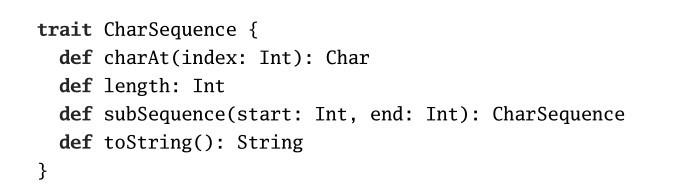
虽然 String类的大部分方法都适用于 CharSequence,Java的CharSequence接口仅声明了四个方法。而如果CharSequence接口包括了完整的String接口方法，又势必会给CharSequence的实现者带来巨大的负担。每个用Java实现CharSequence的程序员都需要多实现数十个方法。由于Scala的特质能包含具体方法，这让编写富接口变得方便得多。

给特质添加具体方法让瘦接口和富接口之间的取舍变得严重倾向于富接口。不同于Java，给Scala特质添加具体方法是一次性的投入。你只需要在特质中实现这些方法一次，而不需要在每个混入该特质的类中重新实现一遍。因此，跟其他没有特质的语言相比，在Scala中实现的富接口的代价更小。

要用特质来丰富某个接口，只需定义一个拥有为数不多的抽象方法（接口中瘦的部分）和可能数量很多的具体方法（这些具体方法基于那些抽象方法编写）的特质。然后，你就可以将这个增值（enrichment）特质混入到某个类，在类中实现接口中瘦的部分，最终得到一个拥有完整富接口实现的类。

## 12.3 示例：矩形对象
图形类库通常有许多不同的类来表示矩形。例如窗体、位图图片，以及用鼠标圈定的区域等。为了让这些矩形对象更加易于使用，我们的类库最好能提供一些坐标相关的查询，比如width、height、left、right、toLeft，等等。不过，存在很多这样的方法，有它们很好，但是对于类库编写者而言，在Java类库中为所有的矩形对象提供全部方法是个巨大的负担。作为对比，如果这样的类库是Scala编写的，类库作者就可以用特质来轻松地对所有想要这些功能的类加上这些便利方法。
首先，可以设想一下不用特质的情况下，代码会是什么样的。应该会有某种基本的几何类，比如Point和Rectangle：


In [69]:
class Point(val x: Int, val y: Int)
class Rectangle(val topLeft: Point, val bottomRight: Point){
    def left = topLeft.x
    def right = bottomRight.x
    def width = right - left
    //以及更多方法
}

defined class Point
defined class Rectangle

这里的Rectangle类在主构造方法中接收两个point：分别表示左上角和右下角的坐标。它接下来实现了许多遍历方法，比如left、right和width，做法是对这两个坐标点执行简单的计算。

图形库可能会有的另一个类是2D图形组件：


In [70]:
abstract class Component {
    def topLeft: Point
    def bottomRight: Point
    
    def left = topLeft.x
    def right = bottomRight.x
    def width = right - left
}

defined class Component

**注意两个类的left、right和width的定义完全一致**。对于任何其他表示矩形对象的类，除了细微差异外，这些方法也会是相同的。

这些重复代码可以用增值特质来消除。这个特质将会包含两个抽象方法：一个返回对象左上角的坐标，另一个返回右下角的坐标。然后它可以提供所有其他几何查询相关方法的具体实现。示例12.5给出了样子：


In [71]:
trait Rectangular {
    def topLeft: Point //这里使用了无参方法，见10.3节
    def bottomRight: Point
    
    def left = topLeft.x
    def right = bottomRight.x
    def width = right - left
}

defined trait Rectangular

Component类可以混入这个特质来获取所有由Rectangular提供的几何查询方法：

In [72]:
abstract class Component extends Rectangular{
    //其他方法
}

defined class Component

同理，Rectangle自己也可以混入这个特质：

In [73]:
class Rectangle(val topLeft: Point, val bottomRight: Point) extends Rectangular{
    //其他方法
}

defined class Rectangle

有了这些定义，你就可以创建一个Rectangle并调用其几何查询方法，比如width和left：

In [74]:
val rect = new Rectangle(new Point(1,1),new Point(10,10))

rect: Rectangle = ammonite.$sess.cmd72$Helper$Rectangle@1cf8912

In [75]:
rect.left

res74: Int = 1

In [76]:
rect.right

res75: Int = 10

In [77]:
rect.width

res76: Int = 9

## 12.4 Ordered特质

比较（对象大小）是另一个富接口会带来便捷的领域。当你需要比较两个对象来对它们排序时，如果有这么一个方法可以调用来明确你要的比较，就会很方便。如果你 要的是“小于”，可以说<，而如果你要的是“小于等于”，可以说<=。如果用一个瘦的比较接口，可能只能用<方法，而有时可能需要编写 类似“（x < y） || （x == y）”这样的代码。而一个富接口可以提供所有常用的比较操作，这样你就可以直接写下如同“x <= y”这样的代码。

在看Ordered的具体实现之前，设想一下没有它你需要怎么完成比较。假定你用第6章的Rational类，然后给它添加比较操作。你可能会做出类似这样的代码：[1]



In [78]:
class Rational(n: Int, d: Int) {
    def < (that: Rational) = 
        this.numer *that.denom < that.numer * this.denom
    def > (that: Rational) = that < this
    def <= (that: Rational) = (this < that) || (this == that)
    def >= (that: Rational) = (this > that) || (this == that)

  require(d != 0)

  private val g = gcd(n.abs, d.abs)
  val numer = n / g
  val denom = d / g

  def this(n: Int) = this(n, 1)

  def + (that: Rational): Rational =
    new Rational(
      numer * that.denom + that.numer * denom,
      denom * that.denom
    )

  def + (i: Int): Rational =
    new Rational(numer + i * denom, denom)

  def - (that: Rational): Rational =
    new Rational(
      numer * that.denom - that.numer * denom,
      denom * that.denom
    )

  def - (i: Int): Rational =
    new Rational(numer - i * denom, denom)

  def * (that: Rational): Rational =
    new Rational(numer * that.numer, denom * that.denom)

  def * (i: Int): Rational =
    new Rational(numer * i, denom)

  def / (that: Rational): Rational =
    new Rational(numer * that.denom, denom * that.numer)

  def / (i: Int): Rational =
    new Rational(numer, denom * i)

  override def toString = numer + "/" + denom

  private def gcd(a: Int, b: Int): Int = 
    if (b == 0) a else gcd(b, a % b)

  override def equals(other: Any): Boolean =
    other match {

      case that: Rational =>
        (that canEqual this) &&
        numer == that.numer &&
        denom == that.denom

      case _ => false
    }

  def canEqual(other: Any): Boolean =
    other.isInstanceOf[Rational]

  override def hashCode: Int = (numer, denom).##

}

defined class Rational

In [79]:
val half = new Rational(1, 2)
val third = new Rational(1, 3)

half < third
half > third
half >= third
half <= third

half: Rational = 1/2
third: Rational = 1/3
res78_2: Boolean = false
res78_3: Boolean = true
res78_4: Boolean = true
res78_5: Boolean = false

这个类定义了四个比较操作符（<、>、<=和>=），这是个经典的展示出定义富接口代价的例子。首先，注意其中的三个比较操作符都 是基于第一个来定义的。例如，>被定义为<的取反，而<=按字面意思定义为“小于或等于”。接下来，注意所有的这三个方法对于任何其他 可以被比较的类来说都是一样的。对于有理数而言，在<=的语义方面，没有任何的不同。在比较的上下文中，<=总是被用来表示“小于或等于”。 总体来说，这个类里有相当多的样板代码，在其他实现了比较操作的类中不会与此有什么不同。

这 个问题如此普遍，Scala提供了专门的特质来解决。这个特质叫作Ordered。使用的方式是将所有单独的比较方法替换成compare方法。 Ordered特质为你定义了<、>、<=和>=，这些方法都是基于你提供的compare来实现的。因此，Ordered特质 允许你只实现一个compare方法来增强某个类，让它拥有完整的比较操作。

以下是用Ordered特质来对Rational定义比较操作的代码：

In [80]:
class Rational(n: Int, d: Int) extends Ordered[Rational] {
  def compare(that: Rational) =
    (this.numer * that.denom) - (that.numer * this.denom)

  require(d != 0)

  private val g = gcd(n.abs, d.abs)
  val numer = n / g
  val denom = d / g

  def this(n: Int) = this(n, 1)

  def + (that: Rational): Rational =
    new Rational(
      numer * that.denom + that.numer * denom,
      denom * that.denom
    )

  def + (i: Int): Rational =
    new Rational(numer + i * denom, denom)

  def - (that: Rational): Rational =
    new Rational(
      numer * that.denom - that.numer * denom,
      denom * that.denom
    )

  def - (i: Int): Rational =
    new Rational(numer - i * denom, denom)

  def * (that: Rational): Rational =
    new Rational(numer * that.numer, denom * that.denom)

  def * (i: Int): Rational =
    new Rational(numer * i, denom)

  def / (that: Rational): Rational =
    new Rational(numer * that.denom, denom * that.numer)

  def / (i: Int): Rational =
    new Rational(numer, denom * i)

  override def toString = numer + "/" + denom

  private def gcd(a: Int, b: Int): Int = 
    if (b == 0) a else gcd(b, a % b)

  override def equals(other: Any): Boolean =
    other match {

      case that: Rational =>
        (that canEqual this) &&
        numer == that.numer &&
        denom == that.denom

      case _ => false
    }

  def canEqual(other: Any): Boolean =
    other.isInstanceOf[Rational]

  override def hashCode: Int = (numer, denom).##

}

defined class Rational

In [81]:
val half = new Rational(1, 2)
val third = new Rational(1, 3)

half < third
half > third
half >= third
half <= third

half: Rational = 1/2
third: Rational = 1/3
res80_2: Boolean = false
res80_3: Boolean = true
res80_4: Boolean = true
res80_5: Boolean = false

每当你需要实现一个按某种比较排序的类，你都应该考虑混入Ordered特质。如果你这样做了，将会提供给类的使用方一组丰富的比较方法。

要小心Ordered特质并不会帮你定义equals方法，因为它做不到。这当中的问题在于用compare来实现equals需要检查传入对象的类型，**而由于（Java的）类型擦除机制，Ordered特质自己无法完成这个检查**。因此，你需要自己定义equals方法，哪怕你已经继承了Ordered。你 将在第30章读到更多相关内容。

## 12.5 作为可叠加修改的特质

现在你已经看过了特质的一个主要用途：将瘦接口转化成富接口。现在我们将转向另一个主要用途：为类提供可叠加的修改。特质让你修改类的方法，而它们的实现方式允许你将这些修改叠加起来。

考虑这样一个例子，对某个整数队列叠加修改。这个队列有两个操作：put，将整数放入队列；get，将它们取出来。队列是先进先出的，所以get应该按照整数被放入队列的顺序返回这些整数。

给定一个实现了这样一个队列的类，可以定义特质来执行如下这些修改：

● Doubling：将所有放入队列的整数翻倍

● Incrementing：将所有放入队列的整数加一

● Filtering：从队列中去除负整数

这三个特质代表了修改（modification），因为它们修改底下的队列类，而不是自己定义完整的队列类。这三个特质也是可叠加的（stackable）。可以从这三个特质中任意选择，将它们混入类，并得到一个带上了你选择的修改的新的类。

示例12.6给出了一个抽象的IntQueue类。IntQueue有一个put方法将新的整数加入队列，以及一个g e t方法从队列中去除并返回整数。示例12.7给出了使用ArrayBuffer的IntQueue的基本实现。

In [82]:
abstract class IntQueue {
    def get(): Int
    def put(x: Int)
}

defined class IntQueue

In [83]:
import scala.collection.mutable.ArrayBuffer
class BasicIntQueue extends IntQueue {
    private val buf = new ArrayBuffer[Int]
    def get() = buf.remove(0)
    def put(x: Int) = {buf += x}
}

import scala.collection.mutable.ArrayBuffer

defined class BasicIntQueue

BasicIntQueue类用一个私有字段持有数组缓冲（array buffer）。get方法从缓冲的一端移除条目，而put方法向缓冲的另一端添加元素。这个实现使用起来是这样的：

In [84]:
val queue = new BasicIntQueue

queue: BasicIntQueue = ammonite.$sess.cmd82$Helper$BasicIntQueue@e4df40

In [85]:
queue.put(10)

In [86]:
queue.put(20)

In [87]:
queue.get()

res86: Int = 10

In [88]:
queue.get()

res87: Int = 20

到目前为止很不错。现在我们来看看如何用特质修改这个行为。示例12.8给出了在放入队列时对整数翻倍的特质。Doubling特质有两个好玩儿的地方。**首先它声明了一个超类IntQueue。这个声明意味着这个特质只能被混入同样继承自IntQueue的类。因此，可以将Doubling混入 BasicIntQueue，但不能将它混入Rational。**

In [89]:
trait Doubling extends IntQueue {
    abstract override def put(x: Int) = {super.put(2*x)}
}

defined trait Doubling

第二个好玩儿的地方是该特质有在一个声明**为抽象的方法里做了一个super调用**。对于普通的类而言这样的调用是非法的，因为它们在运行时必定会失败。不过对于特质来说，这样的调用实际上可以成功。**由于特质中的super调用是动态绑定的，只要在给出了该方法具体定义的特质或类之后混入**， Doubling特质里的super调用就可以正常工作。

对于实现可叠加修改的特质，这样的安排通常是需要的。为了告诉编译器你是特意这样做的，**必须将这样的方法标记为abstract override。这样的修饰符组合只允许用在特质的成员上，不允许用在类的成员上，它的含义是该特质必须混入某个拥有该方法具体定义的类中。**

对于这样一个简单的特质而言，是不是有很多事情发生（在幕后）?！这个特质用起来是这样的：

In [90]:
class MyQueue extends BasicIntQueue with Doubling

defined class MyQueue

In [91]:
val queue = new MyQueue

queue: MyQueue = ammonite.$sess.cmd89$Helper$MyQueue@8a2c51

In [92]:
queue.put(10)

In [93]:
queue.get()

res92: Int = 20

在这个解释器会话的第一行，我们定义了MyQueue类，该类扩展自BasicIntQueue，并混入了Doubling。我们接下来放入一个10，不过由于Doubling的混入，这个10被翻倍。当我们从队列中获取整数时，我们得到的是20。

注意，MyQueue并没有定义新的代码，它只是简单地给出一个类然后混入一个特质。在这种情况下，可以在用new实例化的时候直接给出“BasicIntQueue with Doubling”，而不是定义一个有名字的类。如示例12.9所示：


In [94]:
val queue = new BasicIntQueue with Doubling

queue: BasicIntQueue with Doubling = ammonite.$sess.cmd93$Helper$$anon$1@1113f67

In [95]:
queue.put(10)
queue.get()

res94_1: Int = 20

为了搞清楚如何叠加修改，我们需要定义另外两个修改特质， Incrementing和Filtering。示例12.10给出了这两个特质的实现代码：

In [96]:
trait Incrementing extends IntQueue {
    abstract override def put(x:Int) = {super.put(x+1)}
}
trait Filtering extends IntQueue {
    abstract override def put(x:Int) = {if(x>=0) super.put(x)}
}

defined trait Incrementing
defined trait Filtering

有了这些修改特质，现在你可以为特定的队列挑选想要的修改。举例来说，以下是一个既过滤掉负数同时还对所有数字加一的队列：

In [97]:
val queue = new BasicIntQueue with Incrementing with Filtering

queue: BasicIntQueue with Incrementing with Filtering = ammonite.$sess.cmd96$Helper$$anon$1@1ee246e

In [98]:
queue.put(-1);queue.put(0);queue.put(1)

In [99]:
queue.get()

res98: Int = 1

In [100]:
queue.get()

res99: Int = 2

混入特质的顺序是重要的。[2]确切的规则会在下一节给出，不过粗略地讲，**越靠右出现的特质越先起作用**。当你调用某个带有混入的类的方法时，最靠右端的特质中的方法最先被调用。如果那个方法调用super，它将调用左侧紧挨着它的那个特质的方法，以此类推。在前一例中，Filtering的put最先被调用，所以它首先过滤掉了那些负的整数。Incrementing的put排在第二，因此它做的事情就是在Filtering的基础上对剩下的整数加一。

如果将顺序反过来，那么结果是首先对整数加一，然后再剔除负整数：


In [101]:
val queue = new BasicIntQueue with Filtering with Incrementing
queue.put(-1);queue.put(0);queue.put(1)
queue.get()
queue.get()
queue.get()

queue: BasicIntQueue with Filtering with Incrementing = ammonite.$sess.cmd100$Helper$$anon$1@7916d5
res100_4: Int = 0
res100_5: Int = 1
res100_6: Int = 2

总体而言，以这种风格编写的代码能给你相当高的灵活度。可以通过按不同的组合和顺序混入这三个特质来定义出16种不同的类。对于这么少的代码来说，灵活度是相当高的，因此需要随时留意这样的机会，将代码按照可叠加的修改进行组织。

## 12.6 为什么不用多重继承？
特质是一种从多个像类一样的结构继承的方式，不过它们跟许多其他语言中的多重继承有着重大的区别。**其中一个区别尤为重要：对super的解读**。在多重继承中，super调用的方法在调用发生的地方就已经确定了。**而特质中的super调用的方法取决于类和混入该类的特质的线性化（linearization）**。正是这个差别让前一节介绍的可叠加修改变为可能。

在深入探究线性化之前，我们花一些时间来考虑一下传统多重继承的语言中要如何实现可叠加的修改。假设有下面这段代码，不过这一次按照多重继承来解读，而不是特质混入：


In [102]:
//多重继承思维实验
val q = new BasicIntQueue with Incrementing with Doubling
q.put(42)//应该会调用哪个put？

q: BasicIntQueue with Incrementing with Doubling = ammonite.$sess.cmd101$Helper$$anon$1@b105e3

In [103]:
q.get()

res102: Int = 85

第一个问题是：这次调用执行的是哪一个put方法？也许规则是最后一个超类胜出，那么在本例中Doubling的put会被执行。Doubling于是对其参数翻倍，调用super.put，然后就结束了。不会有加一发生！同理，如果规则是首个超类胜出，那么结果的队列将对整数加一，但不会翻倍。**这么一来没有一种顺序是可行的。**

也许还可以尝试这样一种可能：让程序员自己指定调用super时到底是用哪一个超类的方法。例如，假设有下面这段类Scala的代码，在这段代码中， super看上去显式地调用了Incrementing和Doubling：
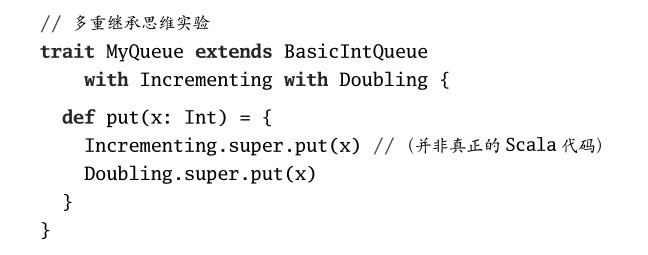
这种方法会带来新的问题（相比这些问题，代码啰唆点根本不算什么），这样做可能发生的情况是基类的put方法被调用两次：一次在加一的时候，另一次在翻倍的时候，**不过两次都不是用加过一或翻过倍的值调用的。**

简单来说，多重继承对这类问题并没有好的解决方案。你需要回过头来重新设计，重新组织你的代码。相比较而言，用Scala特质的解决方案是很直截了当的，只需要简单地混入Incrementing和Doubling,Scala对特质中super的特殊处理完全达到了预期的效果。这种方案跟传统的多重继承相比，很显然有某种不一样，但是这个区别究竟是什么呢？

前面我们提示过了，答案是**线性化**。当你用new实例化一个类的时候， Scala会将类及它所有继承的类和特质都拿出来，将它们线性地排列在一起。然后，当你在某一个类中调用super时，被调用的方法是这个链条中向上最近的那一个。如果除了最后一个方法外，所有的方法都调用了super，那么最终的结果就是叠加在一起的行为。

线性化的确切顺序在语言规格说明书里有描述。这个描述有点复杂，不过你需要知道的要点是，在任何线性化中，类总是位于所有它的超类和混入的特质之前。因此，当你写下调用super的方法时，那个方法绝对是在修改超类和混入特质的行为，而不是反过来。

**注意**  
本节剩下的部分描述线性化的细节。如果你目前不急于理解这些细节，可以安全地略过。

Scala线性化的主要性质可以用下面的例子来说明：假定你有一个Cat类，这个类继承自超类Animal和两个超特质Furry和FourLegged。而FourLegged又扩展自另一个特质HasLegs：
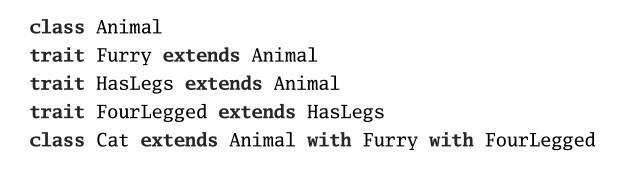
Cat类的继承关系和线性化如图12.1所示。继承是用传统的UML表示法标记的：[3]白色的三角箭头表示继承，其中箭头指向的是超类型。黑化的非三角的箭头表示线性化，其中箭头指向的是super调用的解析方向。
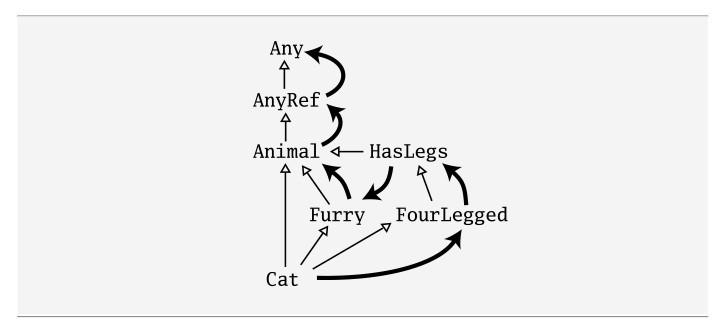
Cat的线性化从后到前的计算过程如下。Cat线性化的最后一个部分是其超类Animal的线性化。这段线性化被直接复制过来不加修改（这些类型的线性化如表12.1所示）。由于Animal并不显式地扩展某个超类也没有混入任何超特质，它默认扩展自AnyRef，而AnyRef扩展自Any。这样Animal的线性化看上去就是这个样子的：
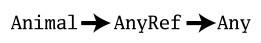
线性化的倒数第二个部分是首个混入（即Furry特质）的线性化，不过所有已经出现在Animal线性化中的类都不再重复出现，每个类在Cat的线性化当中只出现一次。结果是：
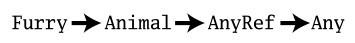
在这个结果之前，是FourLegged的线性化，同样地，任何已经在超类或首个混入中拷贝过的类都不再重复出现：
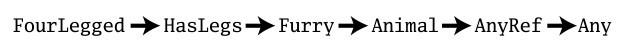
最后，Cat线性化中的第一个类是Cat自己：
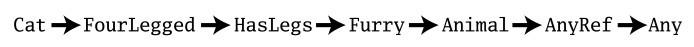
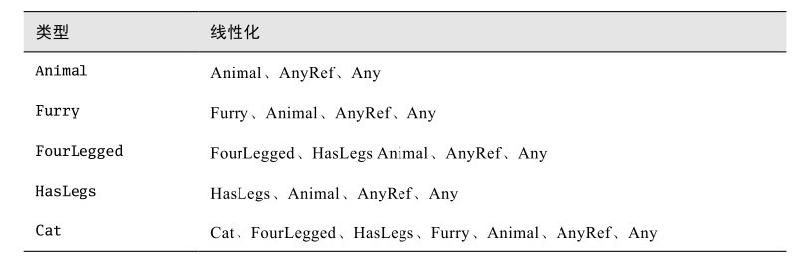
当这些类和特质中的任何一个通过super调用某个方法时，被调用的是在线性化链条中出现在其右侧的首个实现。

## 12.7 要特质还是不要特质？
当你实现某个可复用的行为集合时，都需要决定是用特质还是抽象类。对这个决定，我们并没有某种确定的规则，不过本节包含了一些可以考虑的指导意见。

如果某个行为不会被复用，用具体的类。毕竟它并不是可复用的行为。

如果某个行为可能被用于多个互不相关的类，用特质。只有特质才能被混入类继承关系中位于不同组成部分的类。

如果想要从Java代码中继承某个行为，用抽象类。由于带有实现的特质并没有与之贴近的Java类比，因此从Java类继承特质会比较别扭。不过从Java类继承Scala类跟继承Java类几乎一样。不过有一个例外，如果某个Scala特质只有抽象方法，它会被直接翻译成Java的接口，因此可以放心定义这样的特质，哪怕预期会有Java代码继承自它。关于Java和Scala如何协同工作，可参考第31章。

如果计划将某个行为以编译好的形式分发，且预期会有外部的组织编写继承自它的类，可能会倾向于使用抽象类。这里的问题在于当某个特质增加或减少成员时，任何继承自该特质的类都需要被重新编译，哪怕它们并没有改变。如果外部的使用方只是调用到这个行为，而不是继承，那么使用特质也是可以的。

如果你考虑了上述所有问题之后，仍然没有答案，那么就从特质开始吧。你随时可以改变主意，而一般来说使用特质能让你保留更多选择。

## 12.8 结语
本章展示了特质的工作原理，以及如何在常见的几种场景下使用它们。你看到了特质跟多重继承很相似。但由于特质用线性化解读super，这样做既避免了传统多重继承的某些难处，同时也允许你将行为叠加起来。你还看到了Ordered特质并了解了如何编写自己的增强特质。

既然你已经掌握了特质的这些各个不同的方面，我们有必要退一步，重新把特质当作一个整体来看。特质并不仅仅支持本章中提到的这些惯用法；它们是通过继承实现复用的基础代码单元。因此，许多有经验的Scala程序员都在实现的初期阶段采用特质。每个特质都可以描述整个概念的一小块。随着设计逐步固化和稳定，这些小块可以通过特质混入，被组合成更完整的概念。

________________________________________
[1].这个例子基于示例6.5（110页），具备equals和hashCode，以及必要的修改来确保denom是正数。  
[2].特质一旦被混入类，就可以称它为混入（mixin）。  
[3].Rumbaugh,et al.《The Unified Modeling Language Reference Manual》[Rum04]